# Atomic Simulation Environment + QE

This notebook is my attempt at trying to understand some of the crystalography and DFT terminology used in phonopy.

I'm following the [dft-book](http://kitchingroup.cheme.cmu.edu/dft-book/dft.html) (githib repo [here](https://github.com/jkitchin/dft-book)) and have copied verbatum some of the contents so it's easier to follow here in the notebook.

The dft-book is a fan of using a python package called [ase](https://wiki.fysik.dtu.dk/ase/) (Atomic Simulation Environment). I managed to get it working using a simple `pip install ase`

Later in the notebook I run Quantum Espresso (QE) for the first time on my mac.

In [1]:
from IPython.display import Image
import numpy as np

## [3 Molecules](http://kitchingroup.cheme.cmu.edu/dft-book/dft.html#orgheadline10)
In this chapter we consider how to construct models of molecules, how to manipulate them, and how to calculate many properties of molecules.

### [3.1 Defining and visualizing molecules](http://kitchingroup.cheme.cmu.edu/dft-book/dft.html#orgheadline11)
We start by learning how to define a molecule and visualize it. We will begin with defining molecules from scratch, then reading molecules from data files, and finally using some built-in databases in ase.

#### 3.1.1 From scratch
When there is no data file for the molecule you want, or no database to get it from, you have to define your atoms geometry by hand. Here is how that is done for a CO molecule. We must define the type and position of each atom, and the unit cell the atoms are in.

V = 1000 Angstrom^3


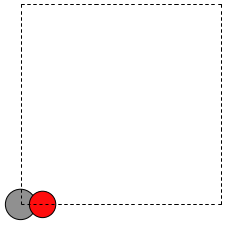

In [2]:
from ase import Atoms, Atom
from ase.io import write

# define an Atoms object
atoms = Atoms([Atom('C', [0., 0., 0.]),
               Atom('O', [1.1, 0., 0.])],
              cell=(10, 10, 10))

print('V = {0:1.0f} Angstrom^3'.format(atoms.get_volume()))

write('simple-cubic-cell.png', atoms, show_unit_cell=2)
Image(filename='simple-cubic-cell.png') 

There are two inconvenient features of the simple cubic cell:

1. Since the CO molecule is at the corner, its electron density is spread over the 8 corners of the box, which is not convenient for visualization later.
2. Due to the geometry of the cube, you need fairly large cubes to make sure the electron density of the molecule does not overlap with that of its images. Electron-electron interactions are repulsive, and the overlap makes the energy increase significantly. Here, the CO molecule has 6 images due to periodic boundary conditions that are 10 Å away. The volume of the unit cell is 1000 Å3.

The first problem is easily solved by centering the atoms in the unit cell. The second problem can be solved by using a face-centered cubic lattice, which is the lattice with the closest packing. We show the results of the centering in Figure fig:co-fcc, where we have guessed values for b until the CO molecules are on average 10 Å apart. Note the final volume is only about 715 Å3, which is smaller than the cube. This will result in less computational time to compute properties.

V = 716 Ang^3


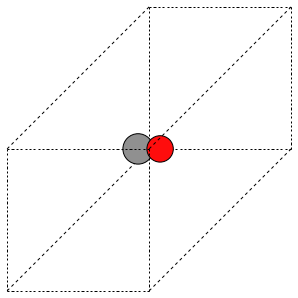

In [3]:
b = 7.1
atoms = Atoms([Atom('C', [0., 0., 0.]),
               Atom('O', [1.1, 0., 0.])],
              cell=[[b, b, 0.],
                    [b, 0., b],
                    [0., b, b]])

print('V = {0:1.0f} Ang^3'.format(atoms.get_volume()))

atoms.center()  # translate atoms to center of unit cell
write('fcc-cell.png', atoms, show_unit_cell=2)
Image(filename='fcc-cell.png') 

At this point you might ask, "How do you know the distance to the neighboring image?" The ag viewer lets you compute this graphically, but we can use code to determine this too. All we have to do is figure out the length of each lattice vector, because these are what separate the atoms in the images. We use the numpy module to compute the distance of a vector as the square root of the sum of squared elements.

In [4]:
from ase import Atoms, Atom

b = 7.1
atoms = Atoms([Atom('C', [0., 0., 0.]),
               Atom('O', [1.1, 0., 0.])],
              cell=[[b, b, 0.],
                    [b, 0., b],
                    [0., b, b]])

# get unit cell vectors and their lengths
(a1, a2, a3) = atoms.get_cell()
print('|a1| = {0:1.2f} Ang'.format(np.sum(a1**2)**0.5))
print('|a2| = {0:1.2f} Ang'.format(np.linalg.norm(a2)))
print('|a3| = {0:1.2f} Ang'.format(np.sum(a3**2)**0.5))

|a1| = 10.04 Ang
|a2| = 10.04 Ang
|a3| = 10.04 Ang


#### 3.1.2 Reading other data formats into a calculation

ase.io.read supports many different file formats

You can read XYZ file format to create ase.Atoms objects. Have a look at `isobutane.xyz`

The first line is the number of atoms in the file. The second line is often a comment. What follows is one line per atom with the symbol and Cartesian coordinates in Å. Note that the XYZ format does not have unit cell information in it, so you will have to figure out a way to provide it. In this example, we center the atoms in a box with vacuum on all sides.

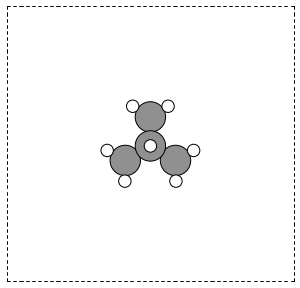

In [5]:
from ase.io import read
atoms = read('isobutane.xyz')
atoms.center(vacuum=5)
write('isobutane-xyz.png', atoms, show_unit_cell=2)
Image(filename='isobutane-xyz.png') 

3.1.3 Predefined molecules
ase defines a number of molecular geometries in the ase.data.molecules database. For example, the database includes the molecules in the G2/97 database curtiss:1063. This database contains a broad set of atoms and molecules for which good experimental data exists, making them useful for benchmarking studies. See this site for the original files.

The coordinates for the atoms in the database are MP2(full)/6-31G(d) optimized geometries. Here is a list of all the species available in ase.data.g2. You may be interested in reading about some of the other databases in ase.data too.

In [6]:
from ase.data import g2
g2.data.keys()

dict_keys(['Be', 'BeH', 'C', 'C2H2', 'C2H4', 'C2H6', 'CH', 'CH2_s1A1d', 'CH2_s3B1d', 'CH3', 'CH3Cl', 'CH3OH', 'CH3SH', 'CH4', 'CN', 'CO', 'CO2', 'CS', 'Cl', 'Cl2', 'ClF', 'ClO', 'F', 'F2', 'H', 'H2CO', 'H2O', 'H2O2', 'HCN', 'HCO', 'HCl', 'HF', 'HOCl', 'Li', 'Li2', 'LiF', 'LiH', 'N', 'N2', 'N2H4', 'NH', 'NH2', 'NH3', 'NO', 'Na', 'Na2', 'NaCl', 'O', 'O2', 'OH', 'P', 'P2', 'PH2', 'PH3', 'S', 'S2', 'SH2', 'SO', 'SO2', 'Si', 'Si2', 'Si2H6', 'SiH2_s1A1d', 'SiH2_s3B1d', 'SiH3', 'SiH4', 'SiO', '2-butyne', 'Al', 'AlCl3', 'AlF3', 'B', 'BCl3', 'BF3', 'C2Cl4', 'C2F4', 'C2H3', 'C2H5', 'C2H6CHOH', 'C2H6NH', 'C2H6SO', 'C3H4_C2v', 'C3H4_C3v', 'C3H4_D2d', 'C3H6_Cs', 'C3H6_D3h', 'C3H7', 'C3H7Cl', 'C3H8', 'C3H9C', 'C3H9N', 'C4H4NH', 'C4H4O', 'C4H4S', 'C5H5N', 'C5H8', 'C6H6', 'CCH', 'CCl4', 'CF3CN', 'CF4', 'CH2NHCH2', 'CH2OCH2', 'CH2SCH2', 'CH3CH2Cl', 'CH3CH2NH2', 'CH3CH2O', 'CH3CH2OCH3', 'CH3CH2OH', 'CH3CH2SH', 'CH3CHO', 'CH3CN', 'CH3CO', 'CH3COCH3', 'CH3COCl', 'CH3COF', 'CH3CONH2', 'CH3COOH', 'CH3NO2', 

Some other databases include the ase.data.s22 for weakly interacting dimers and complexes, and ase.data.extra_molecules which has a few extras like biphenyl and C60.

Here is an example of getting the geometry of an acetonitrile molecule and writing an image to a file. Note that the default unit cell is a 1 Å × Å × Å cubic cell. That is too small to use if your calculator uses periodic boundary conditions. We center the atoms in the unit cell and add vacuum on each side. We will add 6 Å of vacuum on each side. In the write command we use the option show_unit_cell =2 to draw the unit cell boundaries.

unit cell
---------
Cell([13.775328, 13.537479, 15.014576])


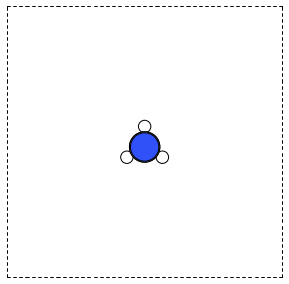

In [7]:
from ase.build import molecule # build instead of structure because of warninig I got
atoms = molecule('CH3CN')

atoms.center(vacuum=6)
print('unit cell')
print('---------')
print(atoms.get_cell())

write('ch3cn.png', atoms, show_unit_cell=2)
Image(filename='ch3cn.png') 

It is possible to rotate the atoms with ase.io.write if you wanted to see pictures from another angle. In the next example we rotate 45 degrees about the $x$-axis, then 45 degrees about the $y$-axis. Note that this only affects the image, not the actual coordinates.

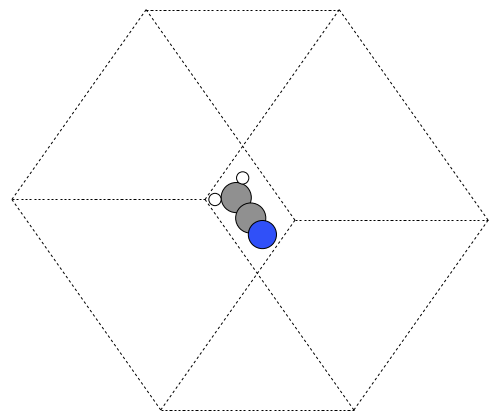

In [8]:
write('ch3cn-rotated.png', atoms,
      show_unit_cell=2, rotation='45x,45y,0z')
Image(filename='ch3cn-rotated.png') 

**...I've not included all the examples from this section**

### [3.3 Simple properties that require single computations](http://kitchingroup.cheme.cmu.edu/dft-book/dft.html#orgheadline13)

#### 3.3.1 Energy and forces
Two of the most important quantities we are interested in are the total energy and the forces on the atoms. To get these quantities, we have to define a calculator and attach it to an ase.Atoms object so that ase knows how to get the data. After defining the calculator a DFT calculation must be run.

Here is an example of getting the energy and forces from a CO molecule. The forces in this case are very high, indicating that this geometry is not close to the ground state geometry. Note that the forces are only along the $x$-axis, which is along the molecular axis. We will see how to minimize this force in Manual determination and Automatic geometry optimization with VASP.

This is your first DFT calculation in the book! See ISMEAR, SIGMA, NBANDS, and ENCUT to learn more about these VASP keywords.

**MATT: I now depart from the book to try out Quantum Expresso (QE)**

ASE can apparently work with QE (see [ASE docs](https://wiki.fysik.dtu.dk/ase/ase/calculators/espresso.html))

I need to install QE on Mac. [YouTube tutorial here](https://www.youtube.com/watch?v=uWhZOwfmV2s).

- Downloaded source code from assets at the bottom of [this page](https://github.com/QEF/q-e/releases/tag/qe-6.5)
- Extracted files and placed them in my home directory under `QE` folder
- Made sure I had fortran compiler `gfortran` and `open-mpi` installed (via brew for mac)
- Navigated into `QE` and as per [instructions](https://github.com/QEF/q-e/tree/qe-6.5#usage) on QE repo I ran `./configure` and then `make all` - this took about 15 mins to complete

In [2]:
from ase.build import bulk
from ase.calculators.espresso import Espresso
from ase.constraints import UnitCellFilter
from ase.optimize import LBFGS

# Make sure you download valid pseudopotential files from this site https://www.quantum-espresso.org/pseudopotentials# 
# and save them in a folder in your home directory called espresso/pseudo
pseudopotentials = {'Na': 'Na.pbe-spnl-rrkjus_psl.1.0.0.UPF',
                    'Cl': 'Cl.pbe-n-rrkjus_psl.1.0.0.UPF'}

rocksalt = bulk('NaCl', crystalstructure='rocksalt', a=6.0)
calc = Espresso(pseudopotentials=pseudopotentials,
                tstress=True, tprnfor=True, kpts=(3, 3, 3))
rocksalt.calc = calc

ucf = UnitCellFilter(rocksalt)
opt = LBFGS(ucf)
opt.run(fmax=0.005)

# cubic lattic constant
print((8*rocksalt.get_volume()/len(rocksalt))**(1.0/3.0))



       Step     Time          Energy         fmax
LBFGS:    0 21:37:28    -1794.297540        0.4529
LBFGS:    1 21:37:36    -1794.305370        0.4296
LBFGS:    2 21:37:45    -1794.344551        0.2882
LBFGS:    3 21:37:53    -1794.362988        0.1060
LBFGS:    4 21:38:00    -1794.361643        0.0240
LBFGS:    5 21:38:06    -1794.362647        0.0008
5.683595878354972


The above outputted a bunch of files with names starting with `espresso` and `pwscf` - I need to understand what they mean

In [3]:
## MATT: going to try and see if this works:
print(rocksalt.get_potential_energy())
print(rocksalt.get_forces())

-1794.3626474607697
[[0. 0. 0.]
 [0. 0. 0.]]


**MATT: I'd like to be able to translate the code below (from dft book) into QE code like above**

In [ ]:
from ase import Atoms, Atom
from vasp import Vasp

co = Atoms([Atom('C', [0, 0, 0]),
            Atom('O', [1.2, 0, 0])],
           cell=(6., 6., 6.))

calc = Vasp('simple-co',  # output dir
            xc='pbe',  # the exchange-correlation functional
            nbands=6,    # number of bands
            encut=350,    # planewave cutoff
            ismear=1,    # Methfessel-Paxton smearing
            sigma=0.01,  # very small smearing factor for a molecule
            atoms=co)

print('energy = {0} eV'.format(co.get_potential_energy()))
print(co.get_forces())

**MATT: I'd like to also play with code from these stanford people https://suncat.stanford.edu/wiki**